# Create a training set of reviews with balanced ratings 

In [1]:
import numpy as np
import pandas as pd
import pickle
import gzip
import math
import random
from sklearn.model_selection import train_test_split

data_path = '../../datasets/'

In [2]:
pickle_in = open(data_path + "amzn_2M_skip2M.pkl","rb")
comments_df = pickle.load(pickle_in)

# Configuration

In [7]:
NB_EACH_CLASS = 41000 # Number of Training + Test samples of each class
TEST_RATIO = 0.2 # Test set
POS_NEG = True  # Merge 1-2 stars into NEG, 4-5 stars into POS, drop 3
MIN_NB_SENTENCES = 5

## Check that balanced classes can be reached for the requested configuration

In [4]:
%load_ext autoreload
%autoreload 2

In [6]:
# takes less than 15 minutes
%reload_ext autoreload
from utils import nb_sentences, not_about_support

minimum = NB_EACH_CLASS + 10
all = {}
for i in range(1,6):
    all[i] = comments_df[comments_df['overall'] == i]
    all[i]['nb_sentences'] = nb_sentences(all[i]['reviewText'])
    all[i] = all[i][all[i]['nb_sentences'] >= MIN_NB_SENTENCES]
    all[i] = all[i][not_about_support(all[i]['reviewText'])]
    
    minimum = min(all[i].shape[0], minimum)
if minimum < NB_EACH_CLASS:
    print('Maximum for balanced classes is ', minimum)
else:
    print('No problem!')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Maximum for balanced classes is  41512


In [8]:
from IPython.display import display
pd.set_option('display.max_colwidth', -1)

for i in range(1,6):
    display(all[i].head(5))

reviewerID        asin                           reviewerName  \
453  A1U1SCQP5D3F9R  0005119367  David's Friend "An Honest Man"          
524  AJP33GUIG4PN8   0005119367  Justin D. Kearns "theLordgiveswisdom"   
600  A2RI2ACXXYPQJB  0005119367  sharp eye klf "klf"                     
666  A3O2VQOWF2D4AC  0011528230  Madelle                                 
702  A2UI4WH2OOB7FY  0130861383  Douglas                                 

      helpful  \
453  [41, 58]   
524  [26, 37]   
600  [13, 23]   
666  [0, 0]     
702  [11, 11]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,nb_sentences
8,A5Y15SAOMX6XA,0000589012,Catherine E. Wetzler,"[12, 16]","I, too, purchased this to use with my patients in early recovery, an ethnically mixed urban/suburban population who complain that their families, friends,s.o.'s ""don't get it"". If you are purchasing this to INFORM for the first time about substance abuse and why it is difficult to ""just quit"", please choose another way. This is overly long, meanders, imparts very little useful information, and lacks energy (I'm a therapist and it put ME to sleep). I don't think it would find a connection with an audience that is hungry for ""ah-hah"" moments and some insights into their loved one's problem. It is basically four people (all middle aged Caucasians) sitting in a darkened room around a table asking each other what they think about a range of topics. It could have been great--personal stories, professional insights, some science, etc., but kind of comes across as a sleepy, low budget afternoon interview show. I will keep looking.",2.0,C+ At Best,1307404800,"06 7, 2011",8
371,A34WKQ6TNI5PK1,0005048524,A Fan,"[1, 1]","Kent Hovind is not a scientist, biologist, or archeologist. He was a Christian school teacher who begain collecting and compiling information and theories about creationism and evolution into a series of lectures and sermons. Some of what he has to say is good, while some is rejected by even creationists. Dr. Hovind is also a believer in conspirarcy theories regarding the UN, the US Government, and 9-11, and is a tax resister (which led to his conviction on tax evasion charges). While this has little to do with his work on creationism, it does call into question his credibility.If you want to research or study creationism, I recommend that you pass on Dr. Hovind's work and check out material by organizations like Answers In Genesis and Creation Ministries International. They employ real scientists and are much more reliable sources of creationist material.",2.0,Not a reliable source,1314921600,"09 2, 2011",6
443,APY0LS7T9UWG2,0005119367,"Critic ""criticism""","[4, 6]","This film is, without a doubt, a Christian perspective on the Joseph story. Or as one of your reviewers commented, there are messianic threads cleverly interwoven throughout. For example, nowhere in the old testament does Jacob EVER say that he gives his inheritance to Joseph. This is an obvious suggestion that Jesus, descended from the tribe of Joseph (and whose nominal ""father"" is Joseph)is to inherit Gods blessings, with Christians inheriting the covenant of the Israelites. And the scene of Joseph imprisoned in the Pharaoh's prison saying to God ""why have you forsaken me"" is NOWHERE mentioned in the old testament; it is strictly put in to provide a Christian slant. Toward the end of the movie, when Joseph goes to see his father, there is a scene in which a large number of crosses appear (briefly). And incidentally, when Joseph and his father meet, the former is shown bowing down to the latter. However, as is clearly stated in the old testament, when Joseph has his dream in which the sun, moon and the stars bow before him, for this dream to be fulfilled (as are all the others in the Joseph story), Jacob (the sun) must bow down to Joseph, not the reverse. I don't have a problem with Christian Messianic films, and I in fact saw this on the Trinity Broadcasting Network, but before everyone falls all over themselves saying what a saintly film this is, please, recognise that it has been made with a specific point of view in mind, namely Christianity, and that there are other perspectives on the Joseph story that are quite different. I think that some honesty on this subject would raise this film above the level of Christian propaganda.",2.0,"Sorry, but don't buy off on the love fest of acolades here.",1276387200,"06 13, 2010",10
481,A2RV78U1G3MGLH,0005119367,Fredrick L. Murphy,"[12, 14]","

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,nb_sentences
195,A2KJO4L7YN3UZW,0005019281,Jules & Eades,"[0, 0]",Should be included in your holiday movies collection. Funny though to be reminded how much TV you watched BEFORE a commercial break back in the early 80's (as it was a made for TV movie). Henry Winkler does a great job playing an American/Depression era version of Mr Scrooge. Corny (but what Christmas Carol version isn't?) but fun.,3.0,Christmas Carol by Henry Winkler,1199145600,"01 1, 2008",5
283,AA8XMUB8TMVMJ,0005019281,Pilgram,"[2, 2]",Worth watching this new version of the classic. It is a little slow in parts but still entertaining. The real negative issue and distraction throughout is Henry Winkler's make up that is supposed to make him look old. It just looks like Henry Winkler with make-up that is supposed to make him look old. Even if you did not know the actor you would know that it was makeup and not an old man. The wig was very good though--looked very authentic.,3.0,Made to look old,1385251200,"11 24, 2013",6
350,A2JP0URFHXP6DO,0005019281,Tim Janson,"[9, 13]","For some reason I always thought this film was older than 1979...in any case this ""American-ized"" version of Dickens' A Christmas Carol stars Henry Winkler as the SCrooge character who is renamed Benedict Slade. Winkler was at the height of his popularity when this ABC made for TV movie came out so I'm certain that's why he was cast. Unfortunately you just can't see anything but Fonzie, even under layers and layers of make-up.The scene is shifted from 1840's London to Depression-era New England, as miserly businessman Slade receives a long-overdue attitude adjustment one Christmas eve when he is visited by three ghostly figures who resemble three of the people whose possessions Slade had seized to collect on unpaid loans. Assuming the roles of the Ghosts of Christmas Past, Present, and Future from Charles Dickens' classic story, the three apparitions force Slade to face the consequences of his skinflint ways, and he becomes a caring, generous, amiable man.In a bit of ridiculousness, the ""Ghost of Christmas Future"" is portrayed by a black man wearing gold chains, dressed in 1979 fashions and listens to disco music. Their ""Ghost of the Future"" jumped a little too far ahead, and is comical by todays standards.Winkler does an admirable job in his role and Dorian Harewood really shines. Still...Dickens is a classic...why ABC felt a need to revise something so perfect is beyond me. This is a good change of pace but if you really like ""A CHristmas Carol"" stick with the Alastair Sim or George C. Scott versions.",3.0,FONZIE PLAYS SCROOGE....AAAYYYYYY!!!!,1102377600,"12 7, 2004",7
532,A3363BZCLRNQSQ,0005119367,Leanne M. Wilkinson,"[3, 3]","If it weren't for the seduction scene with Potiphar's wife, this movie would have been excellent. That scene was so sensual that it was borderline ""R"" rated in our book. I almost shut it off at that scene. Before the actual Biblical account of Jospeh running off, leaving his garment behind him, there is a scene in which Potiphar's wife joins him in a bathing room and (while he is in a pool) clearly and very erotically reaches her hands under the water and strokes his private parts. He doesn't flee that time! This scene ruined the movie for us, and though we've enjoyed other movies from this series, we couldn't keep this movie because of that one scene. Too bad!",3.0,A little too sensual for us to keep this one.,1348185600,"09 21, 2012",7
741,A2AOZQ3WTNVVOK,030714142X,"Lonnie E. Holder ""The Review's the Thing""","[0, 0]","Encyclopedia Brown (Scott Bremner) encounters a mystery surrounding a ghost town when his friends and then he meet an eerie figure on horseback. Is the eerie figure the Wildcat Kid, a character of legend from an era long past?The beautiful young woman who inherited the ghost town is in danger of losing it to taxes. The town is also badly decayed and i

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,nb_sentences
90,A3ECX7DUREGJ7G,0005019281,Cheryl A. Zimmemann,"[2, 2]","This is my favorite rendition of the classic Dickens story ""A Christmas Carol."" Although the versions with George C. Scott and Patrick McNee are also very good, and I watch them at least once every holiday season, they emphasize the British and Victorian aspects of the story. I am fond of ""An American Christmas Carol"" because it is set during the Depression and shows aspects of American society during that period. The primary element missing from this version of the story is that Scrooge's sister and, hence, her son (Scrooge's nephew) are missing from this version, presumably in order to fit the original version within a specific time frame. As a result the story element where the nephew's friends ridicule Scrooge's miserliness, and the corresponding redemptive element after the visitations are missing. I felt that Henry Winkler performed the role of Scrooge admirably, even though he was only 34 at the time. Usually the role is performed by an actor of mature years.",4.0,An American Christmas Carol,1168819200,"01 15, 2007",7
119,A2QXBBR326NW0X,0005019281,Dennis Carlson,"[0, 0]","A brilliant adaptation of Dickson's classic set in early 20th century New England. Well written and well acted, Henry Winkler shines as a young entrepreneur who is more interested in wealth and progress than romance and family, until... I don't want to give it away. Trust me. You'll love it.",4.0,Brilliant Adaptation,1202428800,"02 8, 2008",5
217,A3P98J5DZ00A75,0005019281,"Ken Roberts ""social historian""","[44, 46]","Henry Winkler proves his acting ability in this American version of the Dickens classic. One will actually forget that he was 'The FONZ' and will be amazed at his transformation from nice guy to mean guy back to nice guy. The general feel of this movie, though, is grey. That's the best way to describe it. But then, it was a bleak grey time in American history, with the Great Depression and all. When Dickens originally wrote the book, it was a grey time in England's history as well, so the subdued feeling one gets while watching this 'modern' version fits in well with the spirit of the original story.A nice twist (sorry, Oliver!) to a true classic.By the way, for my money, the finest original version out there is the George C. Scott version followed closely by Alistair Sim.",4.0,grey,1003449600,"10 19, 2001",7
243,A2L207YQOE1HWP,0005019281,Mark C. Butler,"[0, 0]","As we were picking Christmas movies this year, I remembered seeing one with Henry Winkler. Took me a while to find it because I didn't recall the title correctly. Told my wife she would really like it. Was not disappointed. A very good Christmas classic in my book. Winkler is terrific in this role.",4.0,Great twist on the classic.,1353715200,"11 24, 2012",6
278,A15GTCK2TKSLFY,0005019281,perry ander,"[0, 0]","Nice drama- based on the original Christmas Carol movie. This version stars Henry Winkler as Scrooge and takes place during the Depression in America. Winkler plays Scrooge as a business owner who offers home furnishings to be paid off over time. But most people can,t pay off the entire bill due to job scarcity - etc- and Winkler ends up repossessing much of what he has &#34;sold&#34;. Soon &#34;ghosts&#34;- ( passed aquaintances in this version)- of Chistmas past, present, and future appear taking Winkler back through time and into the future showing him his past and what the future holds in store for one of his &#34;value system&#34; , Winkler realizes that he best become more kinder and more considerate of the needs of his town neighbors or risk dying a lonely and embittered man. Dramatic with poignant scenes. Held my attention throughout!",4.0,Henry Winkler Heads a Fine Drama Based Upon a Well Known Story,1389052800,"01 7, 2014",7


reviewerID        asin                           reviewerName  \
11  ANF0AGIV0JCH2   0000589012  GrammaCarole                            
12  A3LDEBLV6MVUBE  0000589012  Jami Hyde "Jami"                        
18  ASB0E2O2FLNA7   0000589012  Kindle Customer jmn                     
20  A3K979KQ7K0S5K  0000589012  Michael Z www.TheWisdomoftheRooms.com   
28  A23PSBNOBPLCOM  0000589012  russtacean                              

     helpful  \
11  [13, 13]   
12  [10, 11]   
18  [2, 2]     
20  [3, 4]     
28  [1, 1]     

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

## Create train and test sets at random, from most recent reviews

In [9]:
train_test = {'train': {}, 'test':{}}
random.seed(0) # for reproducibility
train_idx_filter = np.ones((NB_EACH_CLASS,), dtype=bool)

for i in random.sample(range(NB_EACH_CLASS), 
                                math.floor(NB_EACH_CLASS * TEST_RATIO)):
    train_idx_filter[i] = False

for i in range(1,6):
    #                          use the most recent movies
    train_test['train'][i] = all[i][-NB_EACH_CLASS:][train_idx_filter]
    train_test['test'][i] = all[i][-NB_EACH_CLASS:][~train_idx_filter]
    

In [10]:

if POS_NEG:
    train_test_pos_neg = {'train':{}, 'test':{}}
    train_test_pos_neg['train']['positive'] = pd.concat([
        train_test['train'][4],
        train_test['train'][5]
    ])
    train_test_pos_neg['train']['negative'] = pd.concat([
        train_test['train'][1],
        train_test['train'][2],
    ])
    train_test_pos_neg['test']['positive'] = pd.concat([
        train_test['test'][4],
        train_test['test'][5],
    ])    
    train_test_pos_neg['test']['negative'] = pd.concat([
        train_test['test'][1],
        train_test['test'][2]
    ]) 
else:
    train_test_merged_classes = {}
    train_test_merged_classes['train'] = pd.concat([
        train_test['train'][1],
        train_test['train'][2],
        train_test['train'][3],
        train_test['train'][4],
        train_test['train'][5]
    ])
    train_test_merged_classes['test'] = pd.concat([
        train_test['test'][1],
        train_test['test'][2],
        train_test['test'][3],
        train_test['test'][4],
        train_test['test'][5]
    ])

## Result check

In [11]:
pb = False
if POS_NEG:
    if (train_test_pos_neg['train']['positive'].shape[0] 
                        != NB_EACH_CLASS * 2 * (1-TEST_RATIO)):
        pb = True
        
else:
    if ((train_test_merged_classes['train'].shape[0] 
        + train_test_merged_classes['test'].shape[0] == NB_EACH_CLASS * 5) & 
        (train_test_merged_classes['train'].shape[0] / (1-TEST_RATIO) == NB_EACH_CLASS * 5)):
        pb = True
if pb:
    print('@@@ There was a problem during creation @@@')
else:
    print('No problems found')

No problems found


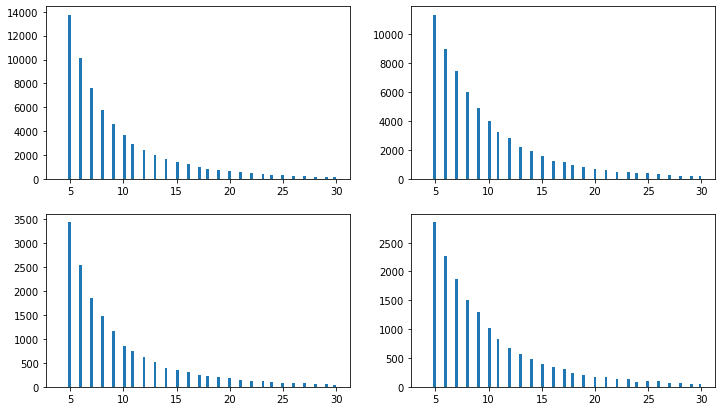

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, axs = plt.subplots(2,2,figsize=(12,7))
for i, tt in enumerate(['train', 'test']):
    for j, pn in enumerate(['positive', 'negative']):
        axs[i][j].hist(train_test_pos_neg[tt][pn]['nb_sentences'],bins=100, range=(4,30));

## Save the balanced training set

In [13]:
if POS_NEG:
    samples_nb = str(NB_EACH_CLASS * 4)
    pickle_out = open(data_path + samples_nb + "_balanced_pos_neg_train_test_reviews_5_no_support.pkl","wb")
    pickle.dump(train_test_pos_neg, pickle_out)    
else:
    samples_nb = str(NB_EACH_CLASS * 5)
    pickle_out = open(data_path + samples_nb + "_balanced_train_test_reviews.pkl","wb")
    pickle.dump(train_test_merged_classes, pickle_out)

pickle_out.close()

In [14]:
train_test_pos_neg['train']['positive'].head(2)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,nb_sentences
1384368,A1YQ6QB2127AJ4,B00005JM55,David Anderson,"[1, 3]","&quot;Legally Blonde 2: Red, White, and Blonde&quot; is the hilarious sequel to &quot;Legally Blonde&quot;. It adds some details that the original left out. It offers new features, keeping the trilogy interesting. The plot was written wonderfully, keeping the humor and the important life messages together. Its humor keeps the audience awaiting the next event and the outcome of every event. Elle Wood's fight to prevent animal cruelty in Washington D.C. offers many interesting twists and turns. They only intense more as the movie continues. Reese Witherspoon's role as Ms. Woods lives up to the original. All other actors offer their own humor and unforgettable quotes: Alana Ubach, Jennifer Coolidge, Luke Wilson, and legendary actors Bob Newhart and Sally Field. The costume designs are amazing. They offer a further unforgettable experience, especially the ones revolving around Ms. Woods. Such movie quality makes &quot;Legally Blonde 2&quot; worth watching more than once. This will keep its audiences entertained. Those interested in watching this movie must watch the original first. Otherwise, the plot will be confusing.",4.0,Blonde Again And Loving It,1069459200,"11 22, 2003",15
1384394,A3OPUUL9DQP8QL,B00005JM55,"Fuchs Joan ""joanfuchs""","[2, 2]","It started out so bad that I nearly left the theatre! After having positively loved the first one, I was downright shocked to see such a mess made of the second. But after 15 minutes it started to improve, and so much that by the end of the movie we were all howling with laughter and really enjoying ourselves. Silly beginning but incredible improvement. So to make a long story short: quite a good sequel.",4.0,Shock!,1060214400,"08 7, 2003",5
